In [66]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
np.set_printoptions(precision=3)

In [67]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
seq_len = len(seq)
seq_len
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}
vals = []
exprs = []

i = 0
nc = 0
nt = 0
# with open('feval-change_numerals-sarnn-1544628893.txt', 'r') as f:
with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['type'] != 'actions':
            assert line_json['type'] == 'input'
            nc += line_json['is_correct']
            nt += 1
            exprs.append(line_json['expr'])
            continue 
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])        
        i += 1
        i %= seq_len

In [68]:
len(seq)

55

mem : seq_len, nsamples, 5, 100

In [69]:
def ncontent(pos, seq):
    if seq[pos] in {'+','-'}:
        return 0
    elif seq[pos] in {'*','/'}:
        return 1
    else:
        return 1

In [70]:
def content(spos, cpos, seq):
    def calc(op, v1, v2):
        if op == '/':
            v = str(int(v1) % int(v2))
        else:
            v = str(eval(''.join([v1, op, v2])) % 10)
        return v
    
    S = []
    l0 = '0'
    l0_t = '0'
    p0 = None
    l1 = '0'
    for i, n in enumerate(seq):
        Nc = len(S)
        if n in {'+', '-'}:
            [S.pop() for _ in range(Nc)]
            p0 = n
        elif n in {'*','/'}:
            S.append((l1, n))
            l0 = l0_t
        else:
            l1 = calc(S[-1][1], S[-1][0], n) if len(S) !=0 else n
            l0_t = l0
            l0 = calc(p0, l0, l1) if p0  is not None else n
            [S.pop() for _ in range(Nc)]
            S.append(l0)
            
        if i == spos:
            if len(S) == 2:
                return S[1-cpos]
            else:
                return S[0]

In [71]:
seq54 = ['1', '-', '1', '/', '1', '*', '9', '-', '1', '/', '7', '*', '6', '/', '4', '-', '3', '*', '5', '*', '2', '*', '3', '/', '8', '+', '5', '+', '7', '*', '7', '+', '6', '*', '3', '/', '6', '-', '3', '/', '9', '-', '2', '*', '7', '-', '8', '*', '6', '*', '4', '+', '1', '/', '6']
content(54, 0, seq54)

'7'

In [72]:
seq54 = ['3', '+', '7', '*', '9', '*', '9', '-', '2', '*', '2', '*', '5', '*', '7', '-', '6', '*', '5', '*', '5', '*', '2', '*', '4', '-', '3', '-', '4', '/', '1', '+', '4', '/', '5', '/', '3', '+', '9', '*', '7', '-', '8', '*', '4', '+', '9', '*', '6', '/', '1', '-', '4', '/', '4']
content(54, 0, seq54)

'9'

In [73]:
expr = '3+2*3/2+5*2'
print(content(3,0,expr))

('2', '*')


In [74]:
expr = '3+2*3/2+5*2'
content(3,1,expr)

'5'

In [75]:
content(3,0,seq)

('6', '*')

In [76]:
''.join(seq)

'8+6*3/2-4*7*4/5-1/5/4*9/9+1+8*4-7*9*9+3/4+7/9-6/6*4+3/3'

In [77]:
train = []
for i, expr in enumerate(exprs[:400]):
    for pos in range(len(seq)):
        n = ncontent(pos, seq)
        if n == 1:
            x = mem[pos][i][0]
            y = content(pos, 0, exprs[i])
            sample = (x, y, i, pos)
#             print(exprs[i][:pos+1], y)
            train.append(sample)

In [78]:
test = []
for i, expr in enumerate(exprs[400:]):
    for pos in range(len(seq)):
        n = ncontent(pos, seq)
        if n == 1:
            x = mem[pos][i][0]
            y = content(pos, 0, exprs[i])
            sample = (x, y, i, pos)
            test.append(sample)

In [79]:
len(test) * 4

18000

In [112]:
lbl2idx = {}
idx2lbl = {}
for sample in train+test:
    lbl = sample[1]
    if lbl not in lbl2idx:
        idx = len(lbl2idx)
        lbl2idx[lbl] = idx
        idx2lbl[idx] =lbl

In [81]:
X_train = np.array([sample[0] for sample in train])
Y_train = np.array([lbl2idx[sample[1]] for sample in train])
X_test = np.array([sample[0] for sample in test])
Y_test = np.array([lbl2idx[sample[1]] for sample in test])

In [82]:
X_train.shape

(18000, 100)

In [83]:
Y_train.shape

(18000,)

In [84]:
X_test.shape

(4500, 100)

In [85]:
Y_test.shape

(4500,)

# fit and test

In [86]:
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [87]:
# clf = linear_model.LogisticRegression()
# clf = LinearDiscriminantAnalysis()
clf = QuadraticDiscriminantAnalysis()
# clf = SVC()
# clf = SVC(gamma=2, C=1)
# clf = KNeighborsClassifier(n_neighbors=1)
# clf = MLPClassifier()
# clf = GaussianNB()

In [88]:
print('score: %f'
      % clf.fit(X_train, Y_train).score(X_test, Y_test))

/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


score: 1.000000


# cluster

In [89]:
from sklearn.manifold import TSNE

In [220]:
def tsne(X, Y):
    colors = {}
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        lbl_idx = Y[i]
        if not lbl_idx in colors:
            R = np.random.rand()
            G = np.random.rand()
            B = np.random.rand()
            colors[lbl_idx] = (R, G, B, 1)
        plt.text(X_norm[i, 0], X_norm[i, 1], str(lbl_idx), color=colors[lbl_idx], 
                     fontdict={'weight': 'bold', 'size': 10})

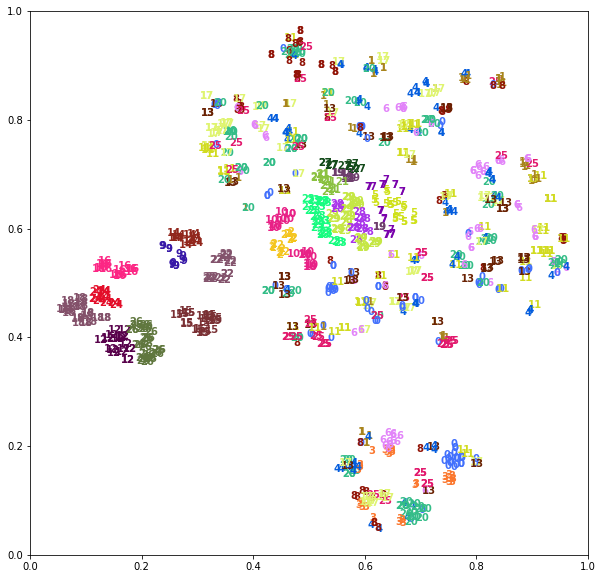

In [221]:
tsne(X_train[:1000], Y_train[:1000])

# accuracy along

In [92]:
ntrain = 400

In [93]:
for i, expr in enumerate(exprs):
    for pos in range(len(seq)):
        n = ncontent(pos, seq)
        if n == 0:
            continue

        x = mem[pos][i][0]
        y = content(pos, 0, exprs[i])
        sample = (x, y, i, pos)
        train.append(sample)

In [94]:
# clf = QuadraticDiscriminantAnalysis()
clf = KNeighborsClassifier(n_neighbors=10)
X_train = []
Y_train = []
X_test = []
Y_test = []
for pos in range(len(seq)):
    X = []
    Y = []
    n = ncontent(pos, seq)
    if n == 0:
        continue
        
    for i, expr in enumerate(exprs):
        n = ncontent(pos, seq)
        if n == 1:
            x = mem[pos][i][0]
            y = content(pos, 0, exprs[i])
            y = lbl2idx[y]
            X.append(x)
            Y.append(y)
    
    X_train.extend(X[:ntrain])
    Y_train.extend(Y[:ntrain])
    X_test.extend(X[ntrain:])
    Y_test.extend(Y[ntrain:])
    
print('score: %f'
      % clf.fit(X_train, Y_train).score(X_test, Y_test))

score: 0.991778


In [95]:
for i in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=i)
    ntrain_iter = int(len(X_train)*0.8)
    print(i, clf.fit(X_train[:ntrain_iter], Y_train[:ntrain_iter]).score(X_train[ntrain_iter:], Y_train[ntrain_iter:]))

1 0.995
2 0.995
3 0.9955555555555555
4 0.9952777777777778
5 0.995
6 0.9955555555555555
7 0.9952777777777778
8 0.9961111111111111
9 0.9955555555555555
10 0.9958333333333333


In [96]:
# clf = KNeighborsClassifier(n_neighbors=3)
clf = SVC()
# clf = QuadraticDiscriminantAnalysis()
print('score: %f'
      % clf.fit(X_train, Y_train).score(X_test, Y_test))

score: 0.822889


In [118]:
clf = KNeighborsClassifier(n_neighbors=3)
# clf = SVC()
# clf = QuadraticDiscriminantAnalysis()
print('score: %f'
      % clf.fit(X_train, Y_train).score(X_test, Y_test))

score: 0.991333


In [98]:
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = SVC()
clf = QuadraticDiscriminantAnalysis()
print('score: %f'
      % clf.fit(X_train, Y_train).score(X_test, Y_test))

/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


score: 0.975778


In [119]:
len(X_train)

18000

In [120]:
len(X_test)

4500

In [121]:
# clf = KNeighborsClassifier(n_neighbors=5)
# clf = SVC(gamma=2, C=1)
scores = {}
for pos in range(len(seq)):
    X = []
    Y = []
    n = ncontent(pos, seq)
    if n == 0:
        continue
        
    for i, expr in enumerate(exprs):
        n = ncontent(pos, seq)
        if n == 1:
            x = mem[pos][i][0]
            y = content(pos, 0, exprs[i])
            y = lbl2idx[y]
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    ntrain = int(0.8 * len(X))
#     scores[pos] = clf.score(X[:ntrain], Y[:ntrain])    
    scores[pos] = clf.score(X[ntrain:], Y[ntrain:])    
#     scores[pos] = clf.fit(X[:ntrain], Y[:ntrain]).score(X[ntrain:], Y[ntrain:])    


In [122]:
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [123]:
scores

{0: 1.0,
 2: 1.0,
 3: 1.0,
 4: 0.99,
 5: 0.98,
 6: 0.98,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 0.98,
 13: 1.0,
 14: 1.0,
 16: 1.0,
 17: 1.0,
 18: 0.99,
 19: 1.0,
 20: 0.99,
 21: 0.98,
 22: 0.95,
 23: 0.97,
 24: 0.98,
 26: 0.99,
 28: 0.99,
 29: 1.0,
 30: 0.99,
 32: 0.99,
 33: 1.0,
 34: 0.99,
 35: 1.0,
 36: 0.97,
 38: 0.99,
 39: 1.0,
 40: 0.99,
 42: 0.99,
 43: 1.0,
 44: 0.99,
 46: 0.99,
 47: 1.0,
 48: 0.99,
 49: 1.0,
 50: 0.98,
 52: 0.99,
 53: 1.0,
 54: 0.99}

In [124]:
clf.means_.shape

AttributeError: 'KNeighborsClassifier' object has no attribute 'means_'

In [105]:
def tsne(X, Y):
    print_num = 5
    colors = {}
    mdl = TSNE(n_components=2)
    X_embedded = mdl.fit_transform(X)
#     X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    
#     for idx in Y[:print_num]:
#         print(idx2lbl[idx])
#     print(X[:print_num, :10])
    
    for i in range(X_norm.shape[0]):
        lbl_idx = Y[i]
        if not lbl_idx in colors:
            R = np.random.rand()
            G = np.random.rand()
            B = np.random.rand()
            colors[lbl_idx] = (R, G, B, 1)
        plt.text(X_norm[i, 0], X_norm[i, 1], str(lbl_idx), color=colors[lbl_idx], 
                     fontdict={'weight': 'bold', 'size': 10})
    return mdl

In [106]:
def tsne_pos(mem, exprs, pos):
    X = []
    Y = []
    n = ncontent(pos, seq)
    if n == 0:
        return -1
        
    for i, expr in enumerate(exprs):
        n = ncontent(pos, seq)
        if n == 1:
            x = mem[pos][i][0]
            y = content(pos, 0, exprs[i])
            y = lbl2idx[y]
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    
    tsne(X, Y)
    return 0

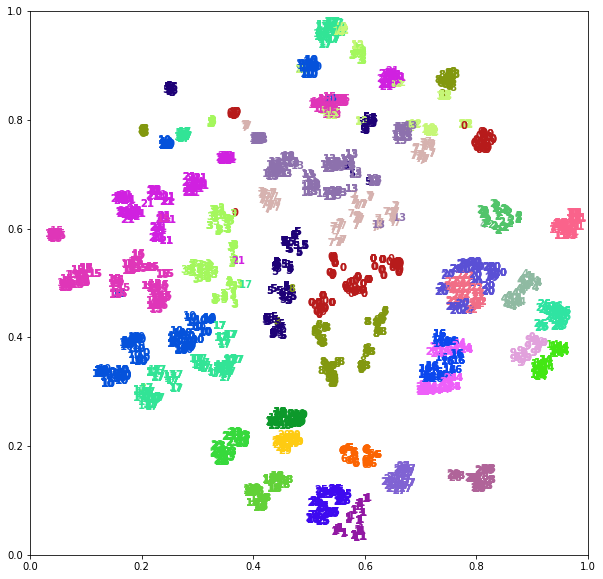

In [212]:
mdl = tsne(X_test, Y_test)

In [125]:
idx2lbl

{0: '1',
 1: '0',
 2: ('1', '/'),
 3: ('0', '*'),
 4: ('1', '*'),
 5: '5',
 6: ('6', '/'),
 7: '9',
 8: '6',
 9: ('3', '*'),
 10: '4',
 11: ('5', '*'),
 12: ('0', '/'),
 13: ('7', '*'),
 14: '3',
 15: ('6', '*'),
 16: ('8', '/'),
 17: '2',
 18: ('3', '/'),
 19: ('2', '*'),
 20: '8',
 21: ('8', '*'),
 22: '7',
 23: ('4', '/'),
 24: ('4', '*'),
 25: ('2', '/'),
 26: ('9', '*'),
 27: ('7', '/'),
 28: ('5', '/'),
 29: ('9', '/')}

In [126]:
X_embedded = TSNE(n_components=2).fit_transform(clf.means_)

AttributeError: 'KNeighborsClassifier' object has no attribute 'means_'

In [127]:
X_embedded

array([[-103.101,   42.636],
       [  -5.651,   89.237],
       [  54.675,  -67.391],
       [ -52.013,  130.946],
       [ -59.126,   14.374],
       [ -20.483,   42.606],
       [ -59.64 ,   74.243],
       [  73.017,  119.668],
       [ 118.279,  -70.177],
       [  74.588,   26.816],
       [  72.093, -123.49 ],
       [-101.425,  -14.044],
       [  24.339,   29.135],
       [-145.946,  -53.057],
       [   1.304,  -55.081],
       [ -90.849,  -68.026],
       [  16.277, -107.328],
       [  87.757,  -24.042],
       [ 134.078,    8.019],
       [  44.602,   74.039],
       [ -88.95 , -123.65 ],
       [  36.87 ,  -18.111],
       [ 110.786,   69.118],
       [-153.313,   17.953],
       [ -38.364,  -88.706],
       [ -49.673,  -36.51 ],
       [ -11.721,   -6.744],
       [-114.104,   98.847],
       [ -23.712, -146.888],
       [  12.825,  140.087]], dtype=float32)

In [135]:
sure_pos = []
for pos, n in enumerate(seq):
#     if pos == 0:
#         sure_pos.append(pos)
#         continue
    
#     if seq[pos-1] in {'+', '-'}:
#         print(pos)
#         sure_pos.append(pos)
#         continue
        
    if n in ['*', '/']:
        sure_pos.append(pos)
        continue

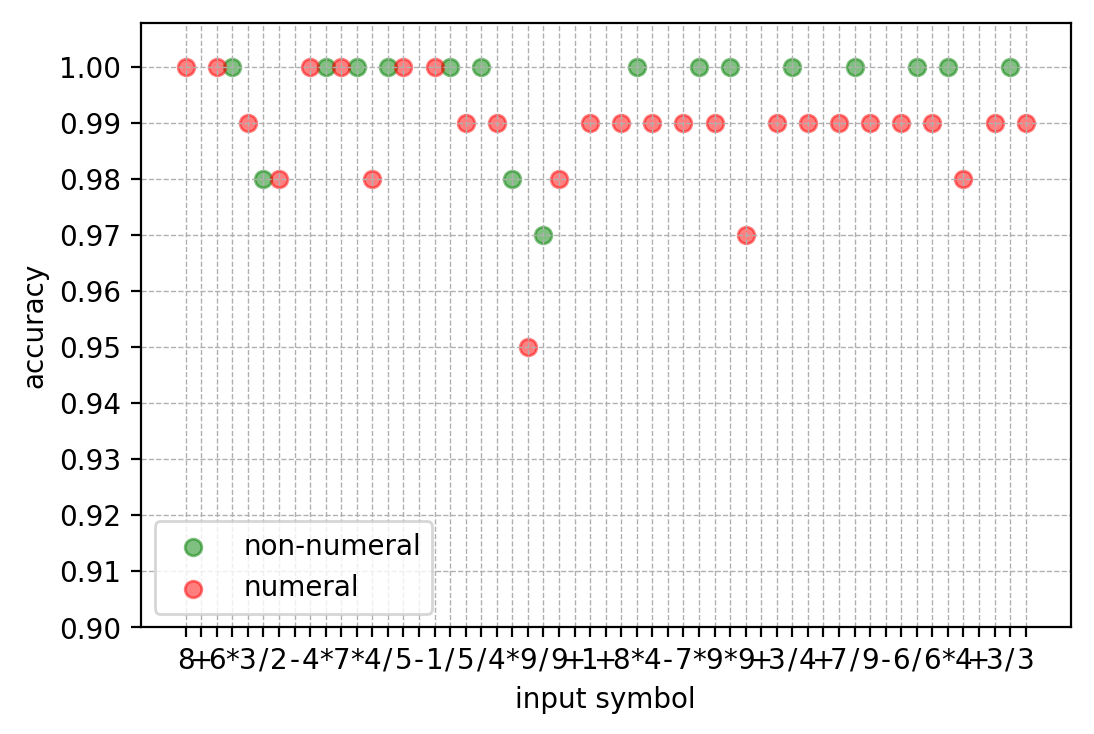

In [142]:
fig, ax = plt.subplots()
fig.dpi = 200
plt.scatter([pos for pos in scores.keys() if pos in sure_pos],
            [scores[pos] for pos in scores.keys() if pos in sure_pos], 
#             marker='o',
           label='non-numeral', color='g', alpha=0.5)
plt.scatter([pos for pos in scores.keys() if pos not in sure_pos], 
            [scores[pos] for pos in scores.keys() if pos not in sure_pos], 
#             marker='o',
           label='numeral', color='r', alpha=0.5)
plt.xticks(np.arange(len(seq)), seq)
plt.xlabel('input symbol', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.yticks(np.arange(0.9, 1.01, 0.01))
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)

In [181]:
sum(scores.values())/len(scores)

0.9913333333333333

In [225]:
seq[42:44+1]

['7', '/', '9']

In [226]:
''.join(seq)

'8+6*3/2-4*7*4/5-1/5/4*9/9+1+8*4-7*9*9+3/4+7/9-6/6*4+3/3'

In [227]:
seq[-1]

'3'

In [76]:
sure_pos = []
for pos, n in enumerate(seq):
    if pos == 0:
        sure_pos.append(pos)
        continue
    
    if seq[pos-1] in {'+', '-'}:
        sure_pos.append(pos)
        continue
        
    if n in ['*', '/']:
        sure_pos.append(pos)
        continue

In [77]:
for pos in scores.keys():
    if pos in sure_pos:
        print(pos, scores[pos])

0 1.0
2 1.0
3 1.0
5 0.99
8 1.0
9 1.0
11 1.0
13 1.0
16 1.0
17 1.0
19 1.0
21 0.99
23 0.99
26 0.99
28 0.99
29 1.0
32 1.0
33 1.0
35 1.0
38 0.99
39 1.0
42 1.0
43 1.0
46 0.99
47 1.0
49 1.0
52 1.0
53 1.0


In [78]:
seq[21:23+1]

['*', '9', '/']

In [79]:
for pos in scores.keys():
    if pos not in sure_pos:
        print(pos, scores[pos])

4 0.67
6 0.82
10 0.65
12 0.76
14 0.81
18 0.57
20 0.75
22 0.74
24 0.82
30 0.09
34 0.09
36 0.11
40 0.08
44 0.1
48 0.1
50 0.11
54 0.1


In [181]:
seq[22:24+1]

['9', '/', '9']

Automatically created module for IPython interactive environment


/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)
/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:

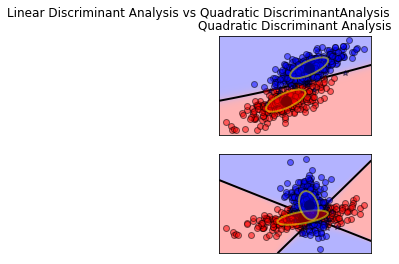

In [196]:
print(__doc__)

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant'
             'Analysis')
plt.show()

In [209]:
dataset_fixed_cov()[0].shape

(600, 2)